In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/benjamin/Masterphase/Mastercode


## Version 1: Own MCMC sampling in python

Sampling from the Hamiltonian $H = \frac{1}{2} \sum_{<i,j>}(1-s_i\cdot s_j)$

Therefore partition function is $Z=\sum_{{s_i}}\exp(-\beta H)$

Sample initial distribution randomly. Step: Do a spin flip, accept if lower energy. If higher energy, accept with probability $\exp(-\frac{\Delta E}{T})$

In [ ]:
from IsingSimulator import IsingSimulator

In [ ]:
# preview of sampling
energies = []
for T in np.linspace(0.5,5,40):
    print(T)
    s = IsingSimulator(J=-1,L=16, T = T)
    s.step(n=100000)
    plt.imshow(s.lattice, interpolation='none')
    plt.show()

### Burn-in
Prepare array of simulators at different temperatures and run for many steps to thermalize

In [ ]:
s = []
for T in np.linspace(0.5,4,20):
    print("At burn-in of Ising MCMC simulator at T={}".format(T))
    s.append(IsingSimulator(J=-1,L=15,T=T))
    # burn-in
    [None for _ in s[-1].step(10000)]

In [ ]:
# check thermalization
for i in range(math.floor(len(s)/2)):
    plt.plot(s[i].energies, color = plt.cm.cool(i/len(s)), label="{}".format(round(s[i].T,1)))
plt.legend(loc='upper left')
plt.ylabel("energy")
plt.xlabel("Accepted step number (spin flip)")
plt.show()

for i in range(math.ceil(len(s)/2), len(s)):
    plt.plot(s[i].energies, color = plt.cm.cool(i/len(s)), label="{}".format(round(s[i].T,1)))
plt.legend(loc='upper left')
plt.ylabel("energy")
plt.xlabel("Accepted step number (spin flip)")
plt.show()

### Sampling to generate Training and Test set

In [ ]:
def sample_batch(simulators, n_simulator, steps=2):
        
    # make sure all simulators have the same grid size
    assert(len(np.unique([s.L for s in simulators]))==1)
    
    # flatten array
    n_total = n_simulator*len(simulators)
    spin_configs = np.zeros((n_total, simulators[0].L**2))
    labels = np.zeros((n_total, 2))
    temperatures = np.zeros(n_total)
    
    for s, i in zip(simulators, range(len(simulators))):
        rows = range(i*n_simulator,(i+1)*n_simulator)
        spin_configs[rows, :] = np.array([l.flatten() for l in s.sample(n_simulator, steps)])
        
        # create labels: above or below critical temperature
        if abs(s.T/s.J) < 2.2691:
            labels[rows,0] = 1
        else:
            labels[rows,1] = 1
            
        temperatures[rows] = abs(s.T/s.J)
            
    
    # shuffle array
    I = np.arange(n_total)
    np.random.shuffle(I)
    
    return((spin_configs[I,:], labels[I,:], temperatures[I]))

In [ ]:
train = sample_batch(s, 500, steps=10)
test = sample_batch(s, 10, steps=100)

## Version 2: Use dataset generated by Lukas' library
Much, much faster since written in C++, more control over thermalization and auto-correlation

In [3]:
from Ising.Data import IsingData

In [4]:
data = IsingData("Ising/large_dataset")

Loading training data
Loading test data


In [5]:
train = data.train_data
test = data.test_data

2.0169504516


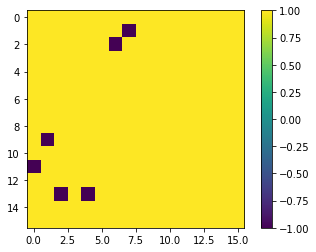

2.0169504516


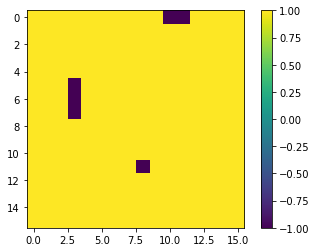

2.27118390003


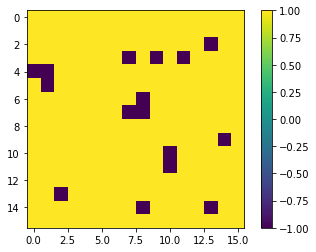

1.3050843476


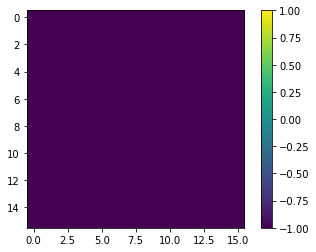

1.3050843476


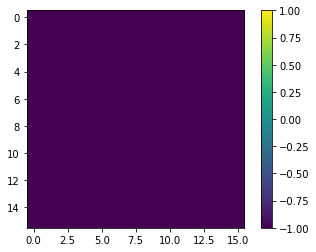

2.98305327435


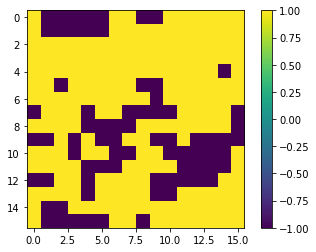

3.79660811031


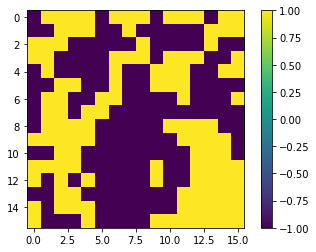

3.79660811031


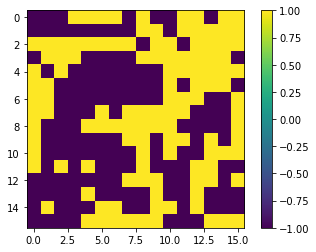

3.79660811031


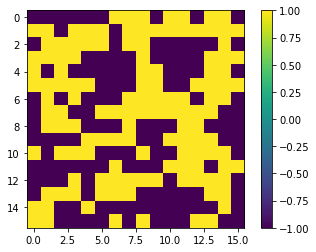

3.89830112037


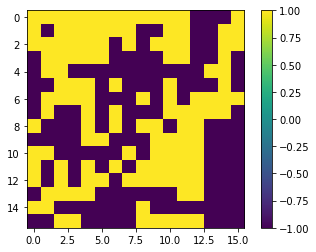

1.76271090836


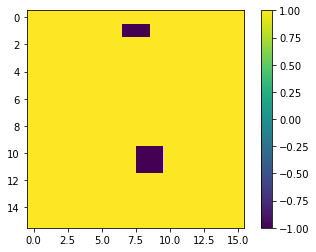

2.77966177076


2.77966177076


2.77966177076


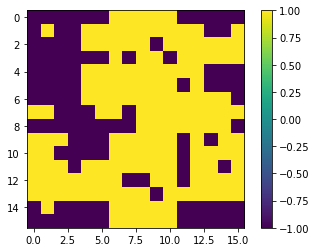

1.35593220339


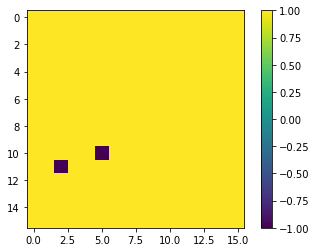

1.35593220339


1.35593220339


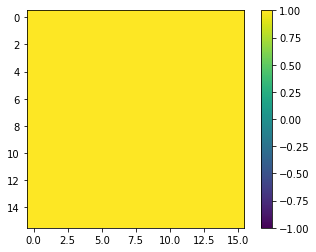

2.57627048779


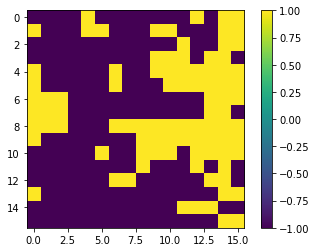

1.6610164424


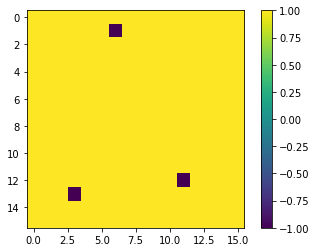

1.6610164424


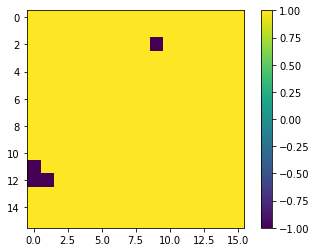

1.6610164424


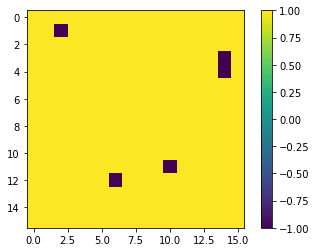

2.1186440678


2.1186440678


2.1186440678


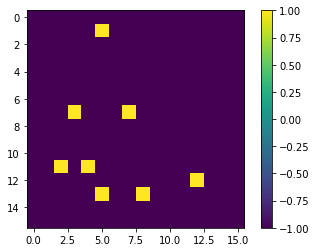

2.1186440678


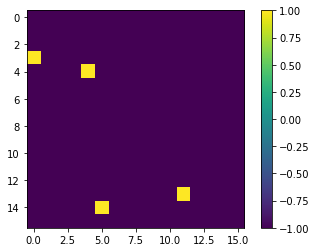

2.9322073657


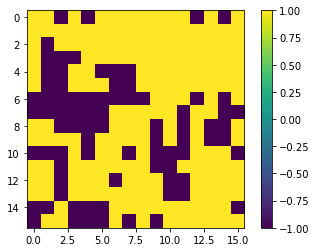

2.9322073657


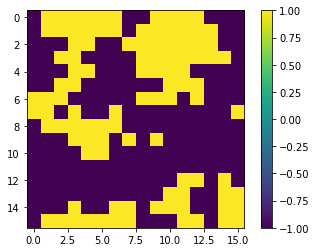

2.9322073657


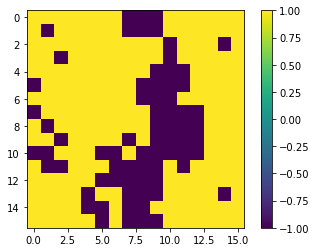

3.64406254669


1.15254245102


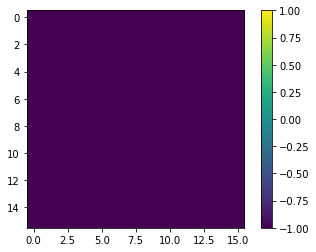

In [8]:
rows = np.random.randint(20000, size=30)

for i in np.sort(rows):
    im = np.reshape(data.train_data[0][i,:], (16,16))
    print(data.train_data[2][i])
    plt.imshow(im, vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()

## Look at Data with TSNE

In [6]:
# subsample training set
rows = range(1,20000)
t2 = (train[0][rows], train[1][rows], train[2][rows])

In [7]:
# dimensionality reduction via tsne
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(t2[0])
t2_pca = pca.transform(t2[0])

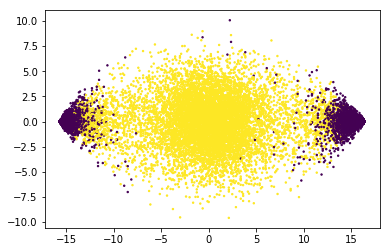

In [14]:
plt.scatter(t2_pca[:,0], t2_pca[:,1], s=2, c=t2[2]>2.269)

In [9]:
from sklearn.manifold import TSNE
train_embedded = TSNE(n_components=2).fit_transform(t2_pca)

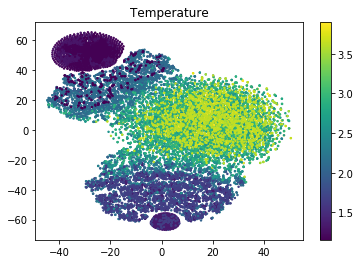

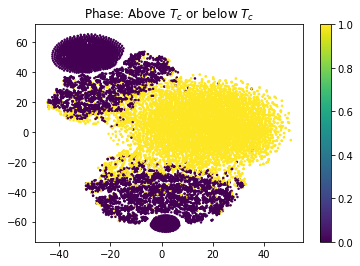

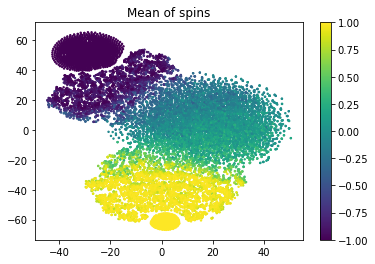

In [10]:
plt.scatter(train_embedded[:,0], train_embedded[:,1], c=t2[2], s=2)
plt.colorbar()
plt.title("Temperature")
plt.show()

plt.scatter(train_embedded[:,0], train_embedded[:,1], c=t2[2]>2.269, s=2)
plt.colorbar()
plt.title("Phase: Above $T_c$ or below $T_c$")
plt.show()

plt.scatter(train_embedded[:,0], train_embedded[:,1], c=np.mean(t2[0], axis=1), s=2)
plt.colorbar()
plt.title("Mean of spins")
plt.show()

## Try to classify with neural networks
### Simple Neural network
Create a very simple neural network with no hidden layers, a relu activation function, cross entropy loss and learning by minibatch gradient descent

In [8]:
from NN.SimpleNN import SimpleNN

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
nn = SimpleNN(16)

In [10]:
nn.train(train[0], train[1], learning_rate = 0.1, epochs=100, valid_data=test[0], valid_labels=test[1])

InternalError: Blas GEMM launch failed : a.shape=(120, 256), b.shape=(256, 2), m=120, n=2, k=256
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_Placeholder_0_0/_1, Variable/read)]]

Caused by op 'MatMul', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/benjamin/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/benjamin/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/benjamin/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/benjamin/.local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/benjamin/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/benjamin/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/benjamin/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/benjamin/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/benjamin/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/benjamin/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/benjamin/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/benjamin/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/benjamin/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/benjamin/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/benjamin/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/benjamin/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/benjamin/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/benjamin/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-01dba3a6b507>", line 1, in <module>
    nn = SimpleNN(16)
  File "/home/benjamin/Masterphase/Mastercode/NN/BaseNN.py", line 17, in __init__
    self._build_model()
  File "/home/benjamin/Masterphase/Mastercode/NN/SimpleNN.py", line 21, in _build_model
    y = tf.nn.relu(tf.matmul(x, W) + b)
  File "/home/benjamin/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1891, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/benjamin/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2437, in _mat_mul
    name=name)
  File "/home/benjamin/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/benjamin/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/benjamin/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(120, 256), b.shape=(256, 2), m=120, n=2, k=256
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_Placeholder_0_0/_1, Variable/read)]]


In [9]:
I = test[2]<1.5
I = range(len(test[2]))
t = test[0][I]
l = test[1][I]

In [ ]:
nn.evaluate(t, l)

In [1]:
nn.confusion(test[0], test[1])

NameError: name 'nn' is not defined

In [2]:
plt.imshow(nn.confusion(test[0], test[1]), vmax=1)
plt.colorbar()

NameError: name 'plt' is not defined

In [16]:
t, acc = nn.evaluate_T_dependence(test)
plt.scatter(t,acc)

### Add hidden layer to neural network
modify previous architecture by adding a fully connected hidden layer and using the Adam Optimizer (adaptive moments) rather than simple gradient descent

In [17]:
from NN.PaperNN import PaperNN
pnn = PaperNN(16)

In [18]:
pnn.train(train[0], train[1], learning_rate = 1e-4, epochs=150, valid_data=test[0], valid_labels=test[1])

Training 150 epochs took 72.59s
Accuracy is 0.9599999785423279


In [19]:
plt.imshow(pnn.confusion(test[0], test[1]))
plt.colorbar()

In [35]:
t, acc = nn.evaluate_T_dependence(test)
plt.scatter(t, acc)
plt.xlabel("Temperature/K")
plt.ylabel("Accuracy")

Text(0,0.5,'Accuracy')

### Use a convolutional neural network
Get fancy: Convolutional layer with 32 filters on 3x3 window, followed by 2x2 maxpool, followed by fully connected layer, followed by readout layer

In [25]:
from NN.ConvNN import ConvNN
cnn = ConvNN(16)

In [26]:
cnn.train(train[0], train[1], learning_rate = 1e-4, epochs=80, valid_data=test[0], valid_labels=test[1])

After 20.343s of training (epoch 14/80)
Accuracy is 0.9700000286102295
After 41.307s of training (epoch 28/80)
Accuracy is 0.9599999785423279
After 62.181s of training (epoch 42/80)
Accuracy is 0.9599999785423279
After 82.956s of training (epoch 56/80)
Accuracy is 0.9599999785423279
After 103.764s of training (epoch 70/80)
Accuracy is 0.9599999785423279
Training 80 epochs took 119.93s
Accuracy is 0.9599999785423279


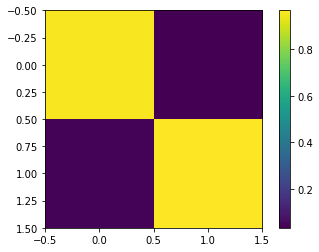

In [28]:
plt.imshow(cnn.confusion(test[0],test[1]))
plt.colorbar()

Text(0.5,0,'Temperature/K')

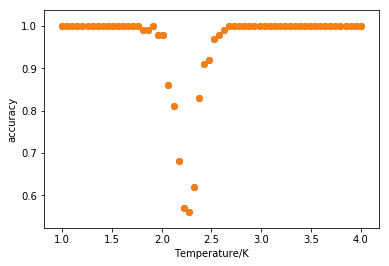

In [31]:
temperatures, accuracies = cnn.evaluate_T_dependence(test)    
plt.scatter(temperatures, accuracies)
plt.ylabel("accuracy")
plt.xlabel("Temperature/K")